In [2]:
pip install torch torchvision torchaudio

Defaulting to user installation because normal site-packages is not writeable
                                              0.0/241.4 MB ? eta -:--:--
                                              0.0/241.4 MB ? eta -:--:--
                                            0.0/241.4 MB 640.0 kB/s eta 0:06:18
                                            0.0/241.4 MB 393.8 kB/s eta 0:10:13
                                            0.1/241.4 MB 409.6 kB/s eta 0:09:50
                                            0.1/241.4 MB 456.6 kB/s eta 0:08:49
                                            0.1/241.4 MB 456.6 kB/s eta 0:08:49
                                            0.1/241.4 MB 435.7 kB/s eta 0:09:14
                                            0.1/241.4 MB 379.3 kB/s eta 0:10:37
                                            0.1/241.4 MB 379.3 kB/s eta 0:10:37
                                            0.1/241.4 MB 369.8 kB/s eta 0:10:53
                                            0.1/241.4 MB

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [5]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),      # randomly rotate image +/- 10 degrees
    transforms.RandomHorizontalFlip(),  # randomly flip left-right 50% of images
    transforms.Resize(224),             # resize shortest side to 224 pixels
    transforms.CenterCrop(224),         # crop to 224x224 at center
    transforms.ToTensor(),              # convert image to PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225]) # ImageNet std
])


In [6]:
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [7]:
root = r"C:\Users\admin\Downloads\Cat-Dog_Pandas-20251015T024917Z-1-001\Cat-Dog_Pandas"


In [8]:
train_data = datasets.ImageFolder(os.path.join(root, 'Train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'Valid'), transform=test_transform)


In [9]:
class_names = train_data.classes
print("Classes:", class_names)
print(f"Training images: {len(train_data)}")
print(f"Validation images: {len(test_data)}")

Classes: ['cat', 'dog', 'panda']
Training images: 2100
Validation images: 300


In [10]:
train_loader = DataLoader(train_data, batch_size=3, shuffle=True)
test_loader = DataLoader(test_data, batch_size=3, shuffle=True)

In [11]:
ResNet18model = models.resnet18(pretrained=True)
for param in ResNet18model.parameters():
    param.requires_grad = False


In [12]:
num_features = ResNet18model.fc.in_features  # 512 for ResNet18

ResNet18model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 3)   # 3 classes: cat, dog, panda
)

In [13]:
ResNet18model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ResNet18model.fc.parameters(), lr=0.001)

In [15]:
ResNet18model = ResNet18model.to(device)

In [17]:
epochs = 3
max_trn_batch = 800
max_tst_batch = 300

train_losses, test_losses = [], []
train_correct, test_correct = [], []

start_time = time.time()

for i in range(epochs):
    ResNet18model.train()
    trn_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        X_train, y_train = X_train.to(device), y_train.to(device)

        y_pred = ResNet18model(X_train)
        loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = torch.max(y_pred, 1)[1]
        trn_corr += (predicted == y_train).sum()

    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())

    # Evaluation
    ResNet18model.eval()
    tst_corr = 0

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break
            X_test, y_test = X_test.to(device), y_test.to(device)

            y_val = ResNet18model(X_test)
            predicted = torch.max(y_val, 1)[1]
            tst_corr += (predicted == y_test).sum()

        val_loss = criterion(y_val, y_test)
        test_losses.append(val_loss.item())
        test_correct.append(tst_corr.item())

In [18]:
val_acc = tst_corr.item() / len(test_data)
torch.save(ResNet18model.state_dict(), 'best_resnet18_model.pth')
print(f"Saved model with val_acc = {val_acc*100:.2f}%")

# Print final accuracy
print(f'Test accuracy: {test_correct[-1]*100/len(test_data):.2f}%')
print(f'Training duration: {time.time() - start_time:.2f} seconds')

Saved model with val_acc = 96.33%
Test accuracy: 96.33%
Training duration: 351.19 seconds


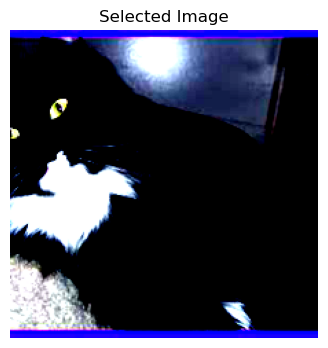

In [24]:
image_index = 54
img, label = test_data[image_index]

plt.figure(figsize=(4, 4))
plt.imshow(img.permute(1, 2, 0).cpu().numpy().clip(0, 1))
plt.axis('off')
plt.title("Selected Image")
plt.show()

In [25]:
ResNet18model.eval()
with torch.no_grad():
    img_input = img.unsqueeze(0).to(device)
    output = ResNet18model(img_input)
    pred = output.argmax(dim=1)

predicted_class = class_names[pred.item()]
true_class = class_names[label]
print(f"True class: {true_class}")
print(f"Predicted class: {predicted_class}")

True class: cat
Predicted class: cat


In [21]:
test_load_all = DataLoader(test_data, batch_size=4, shuffle=False)

all_preds = []
all_labels = []

ResNet18model.eval()
with torch.no_grad():
    for X_test, y_test in test_load_all:
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_val = ResNet18model(X_test)
        predicted = torch.argmax(y_val, dim=1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_test.cpu().numpy())

        del X_test, y_test, y_val, predicted
        torch.cuda.empty_cache()

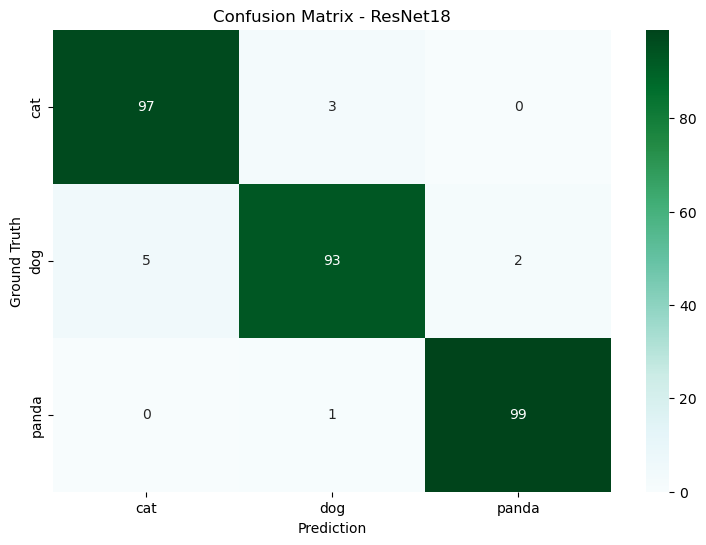

In [22]:
# Confusion matrix
arr = confusion_matrix(all_labels, all_preds)
df_cm = pd.DataFrame(arr, index=class_names, columns=class_names)

plt.figure(figsize=(9, 6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix - ResNet18")
plt.show()

In [23]:
# Save final model
torch.save(ResNet18model.state_dict(), "resnet18_catdogpanda.pth")
print("Model saved as resnet18_catdogpanda.pth")

Model saved as resnet18_catdogpanda.pth
